In [1]:
from numpy import *
from matplotlib.pyplot import *
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

import sys
sys.path.insert(0, 'velocitySlamSeq//slam_seq')

from dynamo_fitting import *
from singleCellPotential import SparseVFC

In [2]:
rcParams.update({'font.size': 18})

# Clustering of Cell Populations using Unspliced Data (uu + ul)

In [3]:
data_uu_kin = []
data_su_kin = []
data_ul_kin = []
data_sl_kin = []
data_pr_kin = []
lT = array([])
T_CP = array([0, 5, 10, 40, 100, 200, 300, 400])
for i, t in enumerate(T_CP):
    data_uu_kin.append(pd.read_csv("./data/simulated_data_protein/uu_treated_kin_T%d.csv"%(t), sep=','))
    data_su_kin.append(pd.read_csv("./data/simulated_data_protein/su_treated_kin_T%d.csv"%(t), sep=','))
    data_ul_kin.append(pd.read_csv("./data/simulated_data_protein/ul_treated_kin_T%d.csv"%(t), sep=','))
    data_sl_kin.append(pd.read_csv("./data/simulated_data_protein/sl_treated_kin_T%d.csv"%(t), sep=','))
    data_pr_kin.append(pd.read_csv("./data/simulated_data_protein/pr_treated_kin_T%d.csv"%(t), sep=','))
    lT = hstack((lT, [i]*len(data_uu_kin[i].values[0])))
U = hstack((data_uu_kin[i].values + data_ul_kin[i].values for i in range(len(T_CP))))
S = hstack((data_su_kin[i].values + data_sl_kin[i].values for i in range(len(T_CP))))
P = hstack((data_pr_kin[i].values for i in range(len(T_CP))))

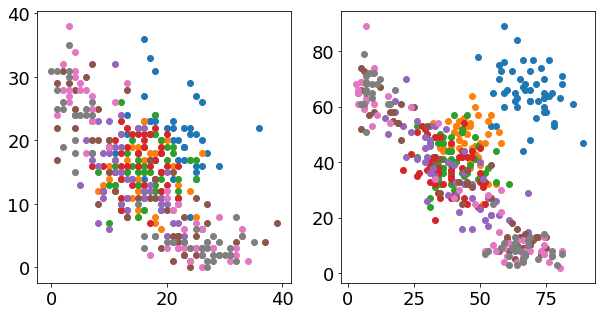

In [4]:
figure(figsize=(10,5))
ax1 = subplot(121)
ax2 = subplot(122)
for i in range(len(T_CP)):
    ax1.scatter(U[0][lT==i], U[1][lT==i])
    ax2.scatter(S[0][lT==i], S[1][lT==i])

In [5]:
# k-means clustering
nc = 4
kmeans = KMeans(n_clusters=nc, random_state=0).fit(U.T)
l = kmeans.labels_

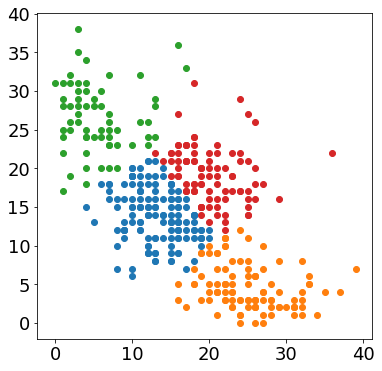

In [6]:
figure(figsize=(6,6))
for i in range(nc):
    scatter(U[0, l==i], U[1, l==i])

# Estimate Gamma and Beta using Degradation Data

In [7]:
data_uu_deg = []
data_su_deg = []
data_ul_deg = []
data_sl_deg = []
T = 150
Tl = array([0, 1, 2, 4, 8])
for i, t in enumerate(Tl):
    data_uu_deg.append(pd.read_csv("./data/simulated_data_protein/uu_treated_deg_T%d_t%d.csv"%(T, t), sep=','))
    data_su_deg.append(pd.read_csv("./data/simulated_data_protein/su_treated_deg_T%d_t%d.csv"%(T, t), sep=','))
    data_ul_deg.append(pd.read_csv("./data/simulated_data_protein/ul_treated_deg_T%d_t%d.csv"%(T, t), sep=','))
    data_sl_deg.append(pd.read_csv("./data/simulated_data_protein/sl_treated_deg_T%d_t%d.csv"%(T, t), sep=','))

## Beta Estimation using Unspliced, Labeled Data (ul)

In [8]:
w1 = array([data_ul_deg[i].values[0, :] for i in range(len(Tl))])
w2 = array([data_ul_deg[i].values[1, :] for i in range(len(Tl))])

Text(0,0.5,'w2')

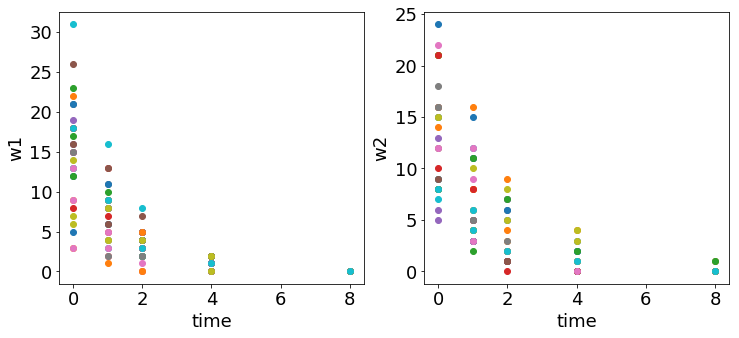

In [9]:
figure(figsize=(12, 5))
subplot(121)
plot(Tl, w1, 'o')
xlabel('time')
ylabel('w1')

subplot(122)
plot(Tl, w2, 'o')
xlabel('time')
ylabel('w2')

In [10]:
#beta1, w1_0 = fit_gamma_labeling(Tl, w1.T, lbound=1)
#beta2, w2_0 = fit_gamma_labeling(Tl, w2.T, lbound=1)
beta1, w1_0 = fit_beta_lsq(Tl, w1.T)
beta2, w2_0 = fit_beta_lsq(Tl, w2.T)
print ('beta1 = %.4f'%beta1)
print ('w1_0 = %.4f'%w1_0)
print ('beta2 = %.4f'%beta2)
print ('w2_0 = %.4f'%w2_0)

beta1 = 0.7362
w1_0 = 14.6044
beta2 = 0.6966
w2_0 = 13.4897


## Gamma Estimation using Spliced, Labeled Data (sl)

In [11]:
l1 = array([data_sl_deg[i].values[0, :] for i in range(len(Tl))])
l2 = array([data_sl_deg[i].values[1, :] for i in range(len(Tl))])

Text(0,0.5,'l2')

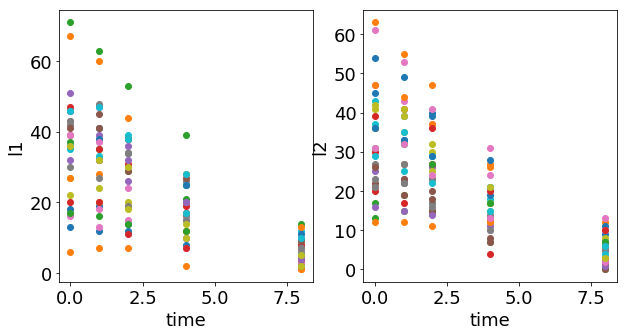

In [12]:
figure(figsize=(10, 5))
subplot(121)
plot(Tl, l1, 'o')
xlabel('time')
ylabel('l1')

subplot(122)
plot(Tl, l2, 'o')
xlabel('time')
ylabel('l2')

In [13]:
gamma1, l1_0 = fit_gamma_splicing(Tl, l1.T, beta1, w1_0)
gamma2, l2_0 = fit_gamma_splicing(Tl, l2.T, beta2, w2_0)
print ('gamma1 = %.4f'%gamma1)
print ('l1_0 = %.4f'%l1_0)
print ('gamma2 = %.4f'%gamma2)
print ('l2_0 = %.4f'%l2_0)

gamma1 = 0.2851
l1_0 = 34.9103
gamma2 = 0.2897
l2_0 = 33.2276


# Estimate Alpha using Clustered Kinetics Data

In [14]:
c = 0
W1 = [array([])]*nc
W2 = [array([])]*nc
for i in range(len(data_ul_kin)):
    n_cells = len(data_ul_kin[i].columns)
    ll = l[c : c + n_cells]
    for j in range(nc):
        W1[j] = hstack((W1[j], data_ul_kin[i].values[0, ll == j]))
        W2[j] = hstack((W2[j], data_ul_kin[i].values[1, ll == j]))
    c += n_cells

In [15]:
A1 = zeros(nc)
A2 = zeros(nc)
t_lab = 1.0
for i in range(nc):
    w1 = array([[0, W1[i][j]] for j in range(len(W1[i]))])
    alpha1 = fit_alpha_synthesis([0, t_lab], w1, beta1)
    #alpha1 = fit_alpha_synthesis([0, t_lab], w1, 1)
    print ('alpha1 = %.4f'%alpha1)
    w2 = array([[0, W2[i][j]] for j in range(len(W2[i]))])
    alpha2 = fit_alpha_synthesis([0, t_lab], w2, beta2)
    #alpha2 = fit_alpha_synthesis([0, t_lab], w2, 1)
    print ('alpha2 = %.4f'%alpha2)
    
    A1[i] = alpha1
    A2[i] = alpha2

alpha1 = 9.1687
alpha2 = 9.6704
alpha1 = 17.9376
alpha2 = 3.3077
alpha1 = 3.9195
alpha2 = 18.2286
alpha1 = 12.3662
alpha2 = 11.7045


In [16]:
V = np.zeros(U.shape)
uc = kmeans.cluster_centers_
sig = 5
for i in range(U.shape[1]):
    x = array([U[0][i], U[1][i]])
    w = array([exp(-(linalg.norm(x - uc[k]))**2/(2*sig**2)) for k in range(nc)])
    w = w/sum(w)
    alpha1 = w.dot(A1)
    alpha2 = w.dot(A2)
    V[0][i] = alpha1 - beta1 * U[0][i]
    V[1][i] = alpha2 - beta2 * U[1][i]
    #V[0][i] = alpha1 - 1 * U[0][i]
    #V[1][i] = alpha2 - 1 * U[1][i]

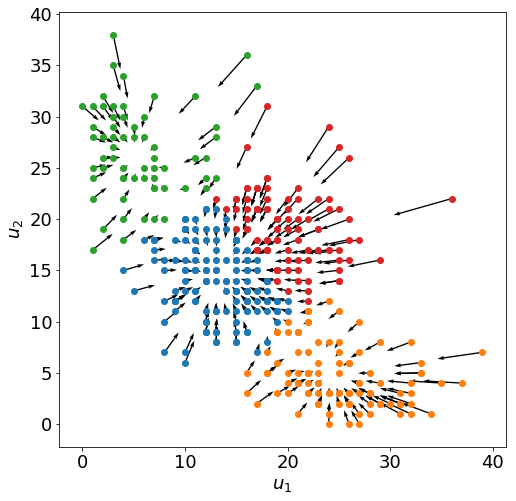

In [17]:
# velocity plot
figure(figsize=(8,8))
quiver(U[0], U[1], V[0], V[1])
xlabel(r'$u_1$')
ylabel(r'$u_2$')

for i in range(nc):
    scatter(U[0][l==i], U[1][l==i], marker='o' )

In [18]:
n_cells = U.shape[1]
data_u = pd.DataFrame(hstack((U, V)), 
                    columns=['u_cell_%d'%(i+1) for i in range(n_cells)] 
                    + ['v_cell_%d'%(i+1) for i in range(n_cells)])
data_u.to_csv('./data/simulated_data/u_vec_n%d.csv'%(n_cells), index=False)

In [19]:
VS = np.zeros(S.shape)
for i in range(S.shape[1]):
    VS[0][i] = beta1 * U[0][i] - gamma1 * S[0][i]
    VS[1][i] = beta2 * U[1][i] - gamma2 * S[1][i]
    #VS[0][i] = 1 * U[0][i] - 0.2 * S[0][i]
    #VS[1][i] = 1 * U[1][i] - 0.2 * S[1][i]

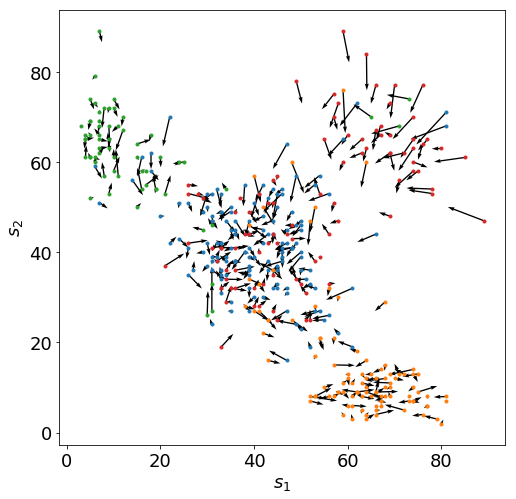

In [20]:
# velocity plot
figure(figsize=(8,8))
quiver(S[0], S[1], VS[0], VS[1])
#xlim([0, 90])
#ylim([0, 90])
xlabel(r'$s_1$')
ylabel(r'$s_2$')

for i in range(nc):
    scatter(S[0][l==i], S[1][l==i], marker='.' )

In [21]:
n_cells = S.shape[1]
data_s = pd.DataFrame(hstack((S, VS)), 
                    columns=['s_cell_%d'%(i+1) for i in range(n_cells)] 
                    + ['v_cell_%d'%(i+1) for i in range(n_cells)])
data_s.to_csv('./data/simulated_data/s_vec_n%d.csv'%(n_cells), index=False)

# Estimate Gamma/Beta using Steady State Assumption

In [22]:
i_10 = int(0.1*len(U[0]))
i_90 = int(0.9*len(U[0]))
mask = zeros(len(U[0]), dtype=bool)
mask[:i_10] = mask[i_90:] = True
gaba1 = fit_gamma(U[0][mask], S[0][mask])
print ('gaba1 = %.4f'%gaba1)
gaba2 = fit_gamma(U[1][mask], S[1][mask])
print ('gaba2 = %.4f'%gaba2)

gaba1 = 0.2871
gaba2 = 0.2936


In [23]:
VS_ss = np.zeros(S.shape)
for i in range(S.shape[1]):
    VS_ss[0][i] = U[0][i] - gaba1 * S[0][i]
    VS_ss[1][i] = U[1][i] - gaba2 * S[1][i]

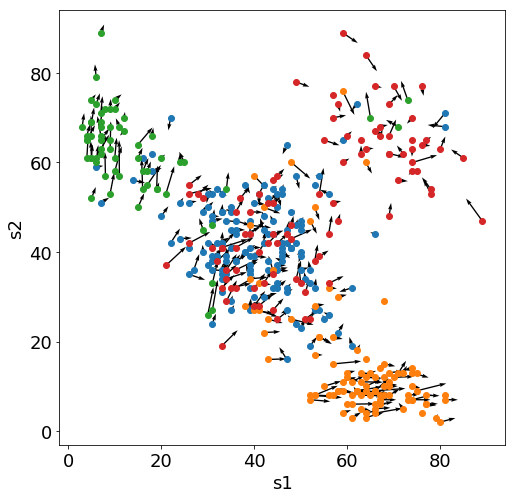

In [24]:
# velocity plot
figure(figsize=(8,8))
quiver(S[0], S[1], VS_ss[0], VS_ss[1])
#xlim([0, 92])
#ylim([0, 92])
xlabel('s1')
ylabel('s2')

for i in range(nc):
    scatter(S[0][l==i], S[1][l==i], marker='o' )

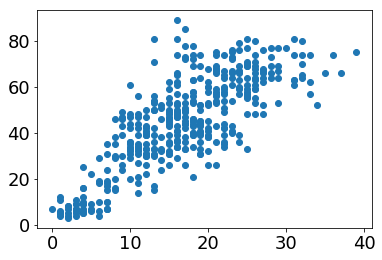

In [25]:
figure()
scatter(U[0], S[0])

# Estimate Alpha using Nearest Neighbors

In [26]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(U.T)
distances, indices = nbrs.kneighbors(U.T)

In [27]:
W1 = array(hstack([data_ul_kin[i].values[0, :] for i in range(len(T_CP))]))
W2 = array(hstack([data_ul_kin[i].values[1, :] for i in range(len(T_CP))]))

In [28]:
A = zeros((2, len(W1)))
for i in range(len(W1)):
    w1 = W1[indices[i]]
    w1 = vstack((zeros(len(w1)), w1)).T
    w2 = W2[indices[i]]
    w2 = vstack((zeros(len(w2)), w2)).T
    A[0][i] = fit_alpha_synthesis(array([0, t_lab]), w1, beta1)
    A[1][i] = fit_alpha_synthesis(array([0, t_lab]), w2, beta2)
    #A[0][i] = fit_alpha_synthesis(array([0, t_lab]), w1, 1)
    #A[1][i] = fit_alpha_synthesis(array([0, t_lab]), w2, 1)

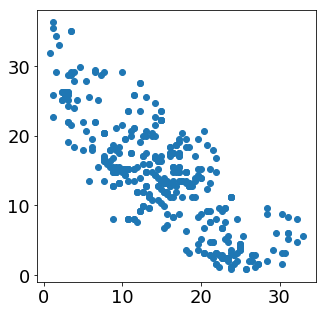

In [29]:
figure(figsize=(5,5))
scatter(A[0]/beta1, A[1]/beta2)

In [30]:
#beta = array([1, 1])
beta = array([beta1, beta2])
V = A - (beta*U.T).T

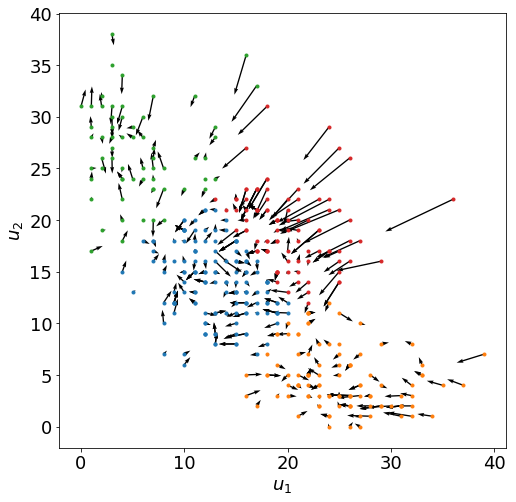

In [31]:
# velocity plot
figure(figsize=(8,8))
quiver(U[0], U[1], V[0], V[1])
xlabel(r'$u_1$')
ylabel(r'$u_2$')

for i in range(nc):
    scatter(U[0][l==i], U[1][l==i], marker='.' )

# Estimate Delta/Eta for Protein Data with Steady State Assumption

In [36]:
i_10 = int(0.1*len(S[0]))
i_90 = int(0.9*len(S[0]))
mask = zeros(len(S[0]), dtype=bool)
mask[:i_10] = mask[i_90:] = True
deta1 = fit_gamma(S[0][mask], P[0][mask])
print ('deta1 = %.4f'%deta1)
deta2 = fit_gamma(S[1][mask], P[1][mask])
print ('deta2 = %.4f'%deta1)

deta1 = 0.0993
deta2 = 0.0993


In [33]:
VP = np.zeros(P.shape)
for i in range(P.shape[1]):
    VP[0][i] = S[0][i] - deta1 * P[0][i]
    VP[1][i] = S[1][i] - deta2 * P[1][i]

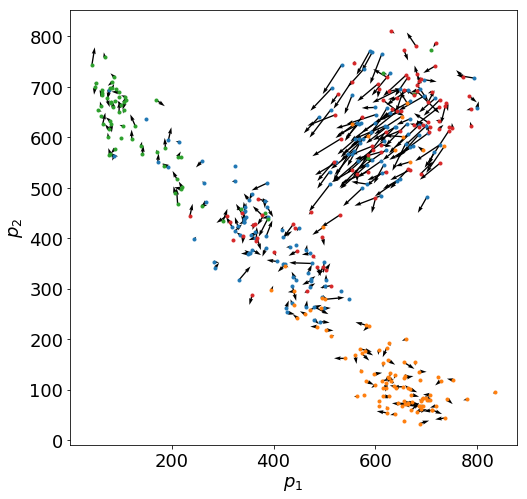

In [34]:
# velocity plot
figure(figsize=(8,8))
quiver(P[0], P[1], VP[0], VP[1])
xlabel(r'$p_1$')
ylabel(r'$p_2$')

for i in range(nc):
    scatter(P[0][l==i], P[1][l==i], marker='.' )

# Vector Field Reconstruction

In [35]:
U; V  # unspliced mRNA and velocity
S; VS # spliced mRNA and velocity
P; VP # spliced mRNA and velocity

array([[-1.23950748e+00, -1.68828415e+01, -1.28674950e+00,
        -6.76881747e+00, -8.45774481e+00, -4.21996749e+00,
        -3.04081015e+00, -4.84862615e+00,  3.31099120e+00,
         1.15487685e+01,  2.66114385e+00,  1.02442092e+01,
         1.58133518e+00, -4.15969881e+00, -5.84862615e+00,
        -4.05383681e+00,  3.82727453e+00,  1.66279255e+00,
         3.84030119e+00,  1.62041516e+00, -4.18740083e+00,
         3.90056987e+00, -1.18681661e+01, -1.30464079e+00,
        -9.15969881e+00, -1.47568240e-02, -8.88119280e+00,
         6.15788718e+00,  3.97221651e+00, -4.55058015e+00,
         2.13435579e+01, -2.15318548e+00, -1.52329942e+01,
        -2.92843482e+00, -3.53755348e+00,  1.69999185e+01,
         1.11122939e+01,  7.11064517e+00,  1.19526765e+01,
        -6.69717083e+00, -9.35188281e+00,  1.03973132e+01,
        -1.27427641e+01, -1.12329942e+01, -2.33234282e+00,
        -5.03429682e+00, -6.10848825e-01,  4.34355786e+00,
         1.17083859e+01, -1.27948708e+01, -1.24707715e+0